In [3]:
library(stringi)
library(lubridate)
library(dplyr)
library(ggplot2)
library(ggpubr)

In [6]:
comcast_data<- read.csv("Comcast Telecom Complaints data.csv",header = TRUE)

#Manipulating column names
names(comcast_data)<- stri_replace_all(regex =  "\\.",replacement = "",str =names(comcast_data))
head(comcast_data)

Ticket,CustomerComplaint,Date,Time,ReceivedVia,City,State,Zipcode,Status,FilingonBehalfofSomeone
250635,Comcast Cable Internet Speeds,22-04-2015,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
242732,Speed and Service,18-04-2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
277946,Comcast Imposed a New Usage Cap of 300GB that punishes streaming.,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
307175,Comcast not working and no service to boot,26-05-2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No
338519,ISP Charging for arbitrary data limits with overage fees,6/12/2015,9:59:40 PM,Internet,Acworth,Georgia,30101,Solved,No


In [7]:
na_vector <- is.na(comcast_data)
length(na_vector[na_vector==T])

[1] 0

In [8]:
comcast_data$Date<- dmy(comcast_data$Date)

In [9]:
monthly_count<- summarise(group_by(comcast_data,Month =as.integer(month(Date))),Count = n())
daily_count<- summarise(group_by(comcast_data,Date),Count =n())
monthly_count<-arrange(monthly_count,Month)

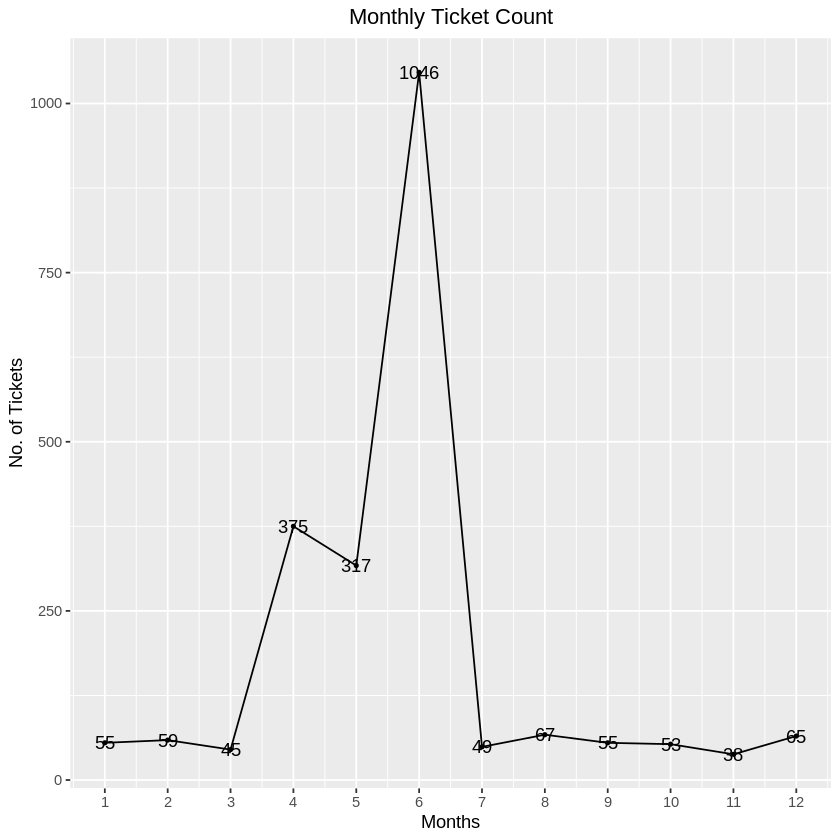

In [10]:
ggplot(data = monthly_count,aes(Month,Count,label = Count))+
        geom_line()+
        geom_point(size = 0.8)+
        geom_text()+
        scale_x_continuous(breaks = monthly_count$Month)+
        labs(title = "Monthly Ticket Count",x= "Months",y ="No. of Tickets")+
        theme(plot.title = element_text(hjust = 0.5))

As we can see that in the month of April,May the tickets are increses but in the month of June it increases drastically, so there might be some reason for which they received high amount of tickets.

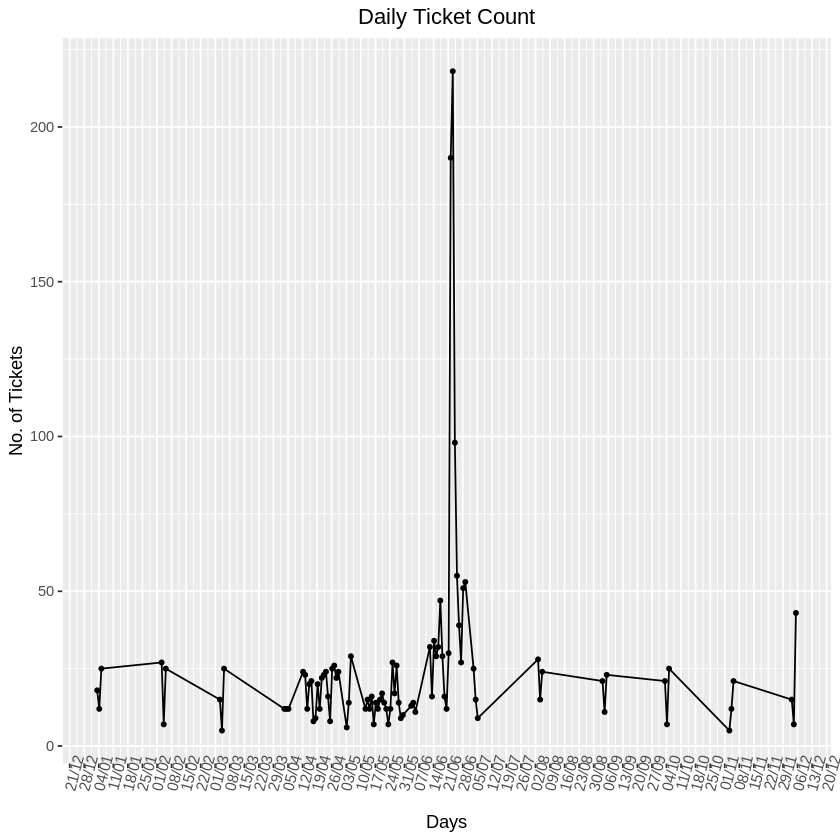

In [11]:
ggplot(data = daily_count,aes(as.POSIXct(Date),Count))+
        geom_line()+
        geom_point(size = 1)+
        scale_x_datetime(breaks = "1 weeks",date_labels = "%d/%m")+
        labs(title = "Daily Ticket Count",x= "Days",y ="No. of Tickets")+
        theme(axis.text.x = element_text(angle = 75),
              plot.title = element_text(hjust = 0.5))

And with the help of above daily chart of tickets we can observe that in second half of June month we recived more tickets with respect to normal days

In [12]:
# Complaint Type Processing
network_tickets<- contains(comcast_data$CustomerComplaint,match = 'network',ignore.case = T)
internet_tickets<- contains(comcast_data$CustomerComplaint,match = 'internet',ignore.case = T)
billing_tickets<- contains(comcast_data$CustomerComplaint,match = 'bill',ignore.case = T)
email_tickets<- contains(comcast_data$CustomerComplaint,match = 'email',ignore.case = T)
charges_ticket<- contains(comcast_data$CustomerComplaint,match = 'charge',ignore.case = T)

comcast_data$ComplaintType[internet_tickets]<- "Internet"
comcast_data$ComplaintType[network_tickets]<- "Network"
comcast_data$ComplaintType[billing_tickets]<- "Billing"
comcast_data$ComplaintType[email_tickets]<- "Email"
comcast_data$ComplaintType[charges_ticket]<- "Charges"

comcast_data$ComplaintType[-c(internet_tickets,network_tickets,
                              billing_tickets,charges_ticket,email_tickets)]<- "Others"

table(comcast_data$ComplaintType)


 Billing  Charges    Email Internet  Network   Others 
     363      139       16      472        1     1233 

As we can observe that there are some complaints from different-different categories and we combined them into one, i.e.- others. So most of the complaints are related to Internet issue. • Creating new Variable ComplaintStatus with values Open and Closed.

In [13]:
open_complaints<- (comcast_data$Status == "Open"| comcast_data$Status =="Pending")
closed_complaints<-(comcast_data$Status == "Closed"| comcast_data$Status =="Solved")
comcast_data$ComplaintStatus[ open_complaints]<-"Open" 
comcast_data$ComplaintStatus[closed_complaints]<- "Closed" 

`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.


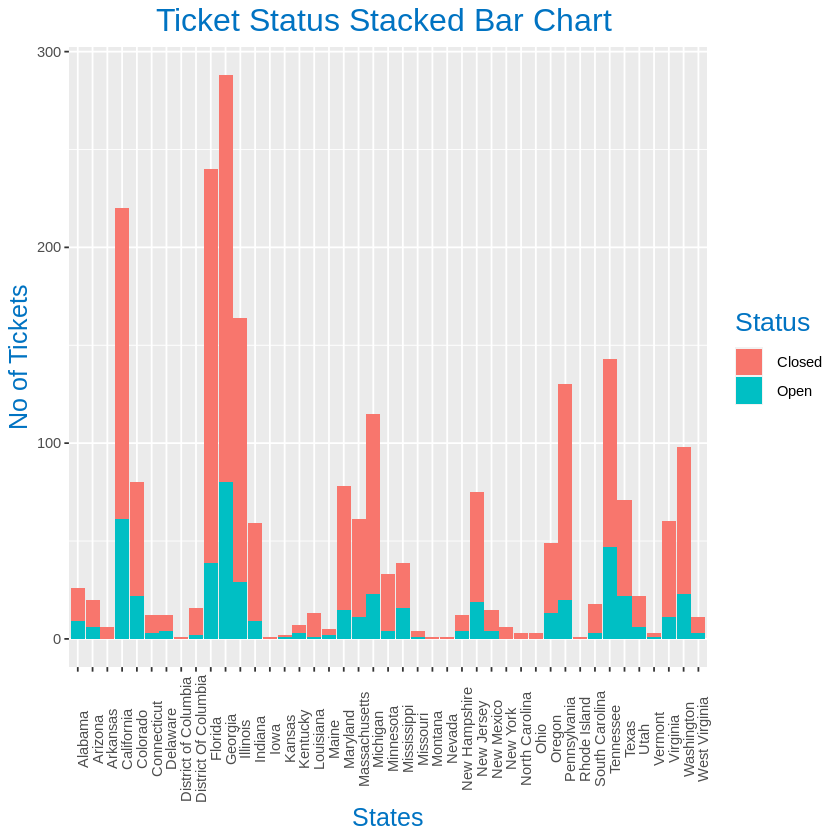

In [14]:
#Creating Stacked barchart for complaints based on State and Status.

comcast_data<- group_by(comcast_data,State,ComplaintStatus)
chart_data<- summarise(comcast_data,Count = n())
ggplot(as.data.frame(chart_data) ,mapping = aes(State,Count))+
      geom_col(aes(fill = ComplaintStatus),width = 0.95)+
      theme(axis.text.x = element_text(angle = 90),
            axis.title.y = element_text(size = 15),
            axis.title.x = element_text(size = 15),
            title = element_text(size = 16,colour = "#0073C2FF"),
            plot.title = element_text(hjust =  0.5))+
      labs(title = "Ticket Status Stacked Bar Chart ",
           x = "States",y = "No of Tickets",
           fill= "Status")

Now it`s clearly shown that the highest number of complaints recorded from the state Georgia and the second highest number of complaints recorded from the state Florida. • Finding State which has Highest number of Unresolved Tickets.

In [15]:
chart_data%>%
            filter(ComplaintStatus == "Open")->
            open_complaints
open_complaints[open_complaints$Count == max(open_complaints$Count),c(1,3)]

State,Count
Georgia,80


As we can observe that State Georgia has maximum number of unresolved tickets and these ticket count is 80. • Calculating Resolution Percentage based on Total and Catagory .

In [16]:
resolved_data <- group_by(comcast_data,ComplaintStatus)
total_resloved<- summarise(resolved_data ,percentage =(n()/nrow(resolved_data))) 
resolved_data <- group_by(comcast_data,ReceivedVia,ComplaintStatus)
Category_resloved<- summarise(resolved_data ,percentage =(n()/nrow(resolved_data)))

`summarise()` has grouped output by 'ReceivedVia'. You can override using the `.groups` argument.


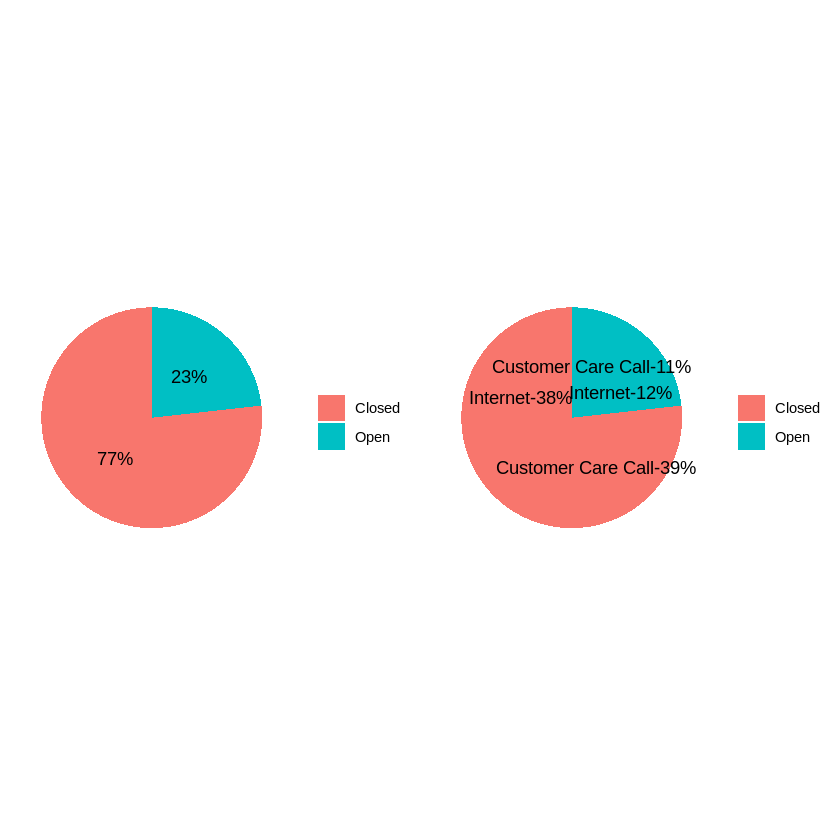

In [17]:
par(mfrow = c(1,2))
total<-ggplot(total_resloved,
       aes(x= "",y =percentage,fill = ComplaintStatus))+
      geom_bar(stat = "identity",width = 1)+
      coord_polar("y",start = 0)+
      geom_text(aes(label = paste0(round(percentage*100),"%")),
                position = position_stack(vjust = 0.5))+
      labs(x = NULL,y = NULL,fill = NULL)+
      theme_classic()+theme(axis.line = element_blank(),
                            axis.text = element_blank(),
                            axis.ticks = element_blank())

# Pie Chart for Category wise Ticket Status
category<-ggplot(Category_resloved,
       aes(x= "",y =percentage,fill = ComplaintStatus))+
      geom_bar(stat = "identity",width = 1)+
      coord_polar("y",start = 0)+
      geom_text(aes(label = paste0(ReceivedVia,"-",round(percentage*100),"%")),
                position = position_stack(vjust = 0.5))+
      labs(x = NULL,y = NULL,fill = NULL)+
      theme_classic()+theme(axis.line = element_blank(),
                            axis.text = element_blank(),
                            axis.ticks = element_blank())
ggarrange(total,category,nrow = 1, ncol = 2)

With the help of above Chart of Total Resolved Vs Category Resolved we can conclude that the total resolved complaints are 77% in which 38% are received the internet and 39% are from the customer care calls.Also we can obserse that there are 23% complaints are still unresolved and in which 12% are received the internet and 11% are from the customer care calls.

Insights:

As per the above analysis we observe that in the 2nd half of the June month Comcast received high amount of complaints in which most of the complaints are releted to internet service issue and the highest amount of complaints are received from the state Georgia. The highest unresolved complaints are reletaed from the state Georgia and the total amount of resolved complaints are 77% in which 38% are received the internet and 39% are from the customer care calls.